# **ENVIRONMENT SETUP**

In [ ]:
import torch

TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '')

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

Fri Nov 11 14:40:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **DATASET PROCESSING**

In [ ]:
from torch_sparse import SparseTensor
import torch_geometric.transforms as T
from ogb.linkproppred import PygLinkPropPredDataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [ ]:
pyg_dataset = PygLinkPropPredDataset(name='ogbl-collab')
data = pyg_dataset[0]
print(data)
split_edge = pyg_dataset.get_edge_split()
edge_index = data.edge_index

Data(num_nodes=235868, edge_index=[2, 2358104], x=[235868, 128], edge_weight=[2358104, 1], edge_year=[2358104, 1])


In [ ]:
data.edge_weight = data.edge_weight.view(-1).to(torch.float)
print(data)
data = T.ToSparseTensor()(data)
print(data)

Data(num_nodes=235868, edge_index=[2, 2358104], x=[235868, 128], edge_weight=[2358104], edge_year=[2358104, 1])
Data(num_nodes=235868, x=[235868, 128], edge_year=[2358104, 1], adj_t=[235868, 235868, nnz=2358104])


In [ ]:
# Considering val edges too along with train edges, as input during inference
val_edge_index = split_edge['valid']['edge'].t()
full_edge_index = torch.cat([edge_index, val_edge_index], dim=-1)
data.full_adj_t = SparseTensor.from_edge_index(full_edge_index).t()
data.full_adj_t = data.full_adj_t.to_symmetric()

In [ ]:
#shift data to device for accelerated GPU training
data = data.to(device)
data

Data(num_nodes=235868, x=[235868, 128], edge_year=[2358104, 1], adj_t=[235868, 235868, nnz=2358104], full_adj_t=[235868, 235868, nnz=1999288])

# **MODEL** 

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.nn import SAGEConv, GCNConv, GraphNorm
from tqdm import tqdm
import random, os
import numpy as np

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [ ]:
class GraphOpwNORM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, norm_flag, conv_type='gcn', dropout=0.1):
        super(GraphOpwNORM, self).__init__()
        self.CONV = GCNConv if conv_type=='gcn' else SAGEConv
        self.norm_flag = norm_flag

        self.conv1 = self.CONV(input_dim, hidden_dim)
        if self.norm_flag:
             self.norm1 = GraphNorm(hidden_dim)
        self.conv2 = self.CONV(hidden_dim, hidden_dim)
        if self.norm_flag:
             self.norm2 = GraphNorm(hidden_dim)
        self.conv3 = self.CONV(hidden_dim, output_dim)
        self.dropout = dropout          

    def forward(self, x, neigh):
        x = self.conv1(x, neigh)
        if self.norm_flag:
             x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, neigh)
        if self.norm_flag:
             x = self.norm2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, neigh)
        return x

In [ ]:
class CollabPred(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, p=0.1):
        super(CollabPred, self).__init__()
        self.dense1 = torch.nn.Linear(in_dim, hidden_dim)
        self.dense2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = torch.nn.Linear(hidden_dim, out_dim)
        self.dropout = p

    def forward(self, node_i, node_j):
        x = node_i * node_j
        x = self.dense1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.dense2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.dense3(x)
        return torch.sigmoid(x)

In [ ]:
def train(model, predictor, data, edges, optimizer, batch_size, epsilon=1e-15):
    model.train()
    predictor.train()
    train_edges = edges['train']['edge'].to(data.x.device)
    train_dataloader = DataLoader(range(train_edges.size(0)), batch_size, shuffle=True)
    total_loss = 0
    total_examples = 0
    for idx in train_dataloader:
        optimizer.zero_grad()
        new_features = model(data.x, data.adj_t)
        pos_edge = train_edges[idx].t()
        pos_sample = predictor(new_features[pos_edge[0]], new_features[pos_edge[1]])
        # Negative Sampling
        neg_edge = torch.randint(0, data.num_nodes, pos_edge.size(), dtype=torch.long, device=new_features.device)
        neg_sample = predictor(new_features[neg_edge[0]], new_features[neg_edge[1]])
        loss = - torch.log(pos_sample + epsilon).mean() - torch.log(1 - neg_sample + epsilon).mean() 
        loss.backward()
        optimizer.step()
        num_examples = pos_sample.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples

In [ ]:
def get_preds(edges, batch_size, node_features):
    preds = []
    for idx in DataLoader(range(edges.size(0)), batch_size):
        edge = edges[idx].t()
        preds += [predictor(node_features[edge[0]], node_features[edge[1]]).squeeze().cpu()]
    return torch.cat(preds, dim=0)

In [ ]:
def eval_hits_50(splits, pos_split, neg_split, evaluator, batch_size, node_features):
    pos_edge = splits[pos_split]['edge'].to(node_features.device)
    neg_edge = splits[neg_split]['edge_neg'].to(node_features.device)

    pos_pred = get_preds(pos_edge, batch_size, node_features) #true collaborations
    neg_pred = get_preds(neg_edge, batch_size, node_features) #false collaborations
    
    return evaluator.eval({'y_pred_pos': pos_pred,'y_pred_neg': neg_pred,})['hits@50']

In [ ]:
def evaluate(model, predictor, data, split_edge, evaluator, batch_size, mode):
    with torch.no_grad():
        model.eval()
        predictor.eval()
        evaluator.K = 50
        if mode == 'train':    # Evaluating Hits@50 on train
            node_features = model(data.x, data.adj_t)
            return eval_hits_50(split_edge, 'train', 'valid', evaluator, batch_size, node_features)
        elif mode == 'val':    # Evaluating Hits@50 on Val
            node_features = model(data.x, data.adj_t)
            return eval_hits_50(split_edge, 'valid', 'valid', evaluator, batch_size, node_features)
        elif mode == 'test':   # Evaluating Hits@50 on test, using both train and val links for test data
            node_features = model(data.x, data.full_adj_t)
            return eval_hits_50(split_edge, 'test', 'test', evaluator, batch_size, node_features)
        else:
            print('INVALID EVAL MODE!!!')

In [ ]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

def plot_history(history, train_hits, val_hits, test_hits, num_epochs, model_type):
      plt.plot(np.arange(0, num_epochs, step=1), train_hits, label='Train Hits@50')
      plt.plot(np.arange(0, num_epochs, step=1), val_hits, label='Val Hits@50')
      plt.plot(np.arange(0, num_epochs, step=1), test_hits, label='Test Hits@50')
      plt.title(f'HISTORY ({model_type})')
      plt.xlabel('Epochs')
      plt.ylabel('Hits@50')
      plt.xticks(np.arange(0, num_epochs, step=20))
      plt.legend(loc='best')
      plt.savefig(model_type+'.png')

# **TRAIN & EVALUATE**

In [ ]:
from ogb.linkproppred import Evaluator

In [ ]:
# HYPERPARAMETERS

HIDDEN_CHANNELS = 256
DROPOUT = 0.1
LR = 6e-4
N_EPOCHS = 200
BATCH_SIZE = 64 * 1024
NORM_FLAG = True
FILTER_TYPE = 'gcn'
model_type = FILTER_TYPE + '_' +'gnorm' if NORM_FLAG else FILTER_TYPE

In [ ]:
model = GraphOpwNORM(data.num_features, HIDDEN_CHANNELS, HIDDEN_CHANNELS, NORM_FLAG, FILTER_TYPE, DROPOUT).to(device)
predictor = CollabPred(HIDDEN_CHANNELS, HIDDEN_CHANNELS, 1, DROPOUT).to(device)
evaluator = Evaluator(name='ogbl-collab')
optimizer = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()),lr=LR)

In [ ]:
history = []
train_hits = []
val_hits = []
test_hits = []
epochs = []

for epoch in tqdm(range(1, 1 + N_EPOCHS)):
    loss = train(model, predictor, data, split_edge, optimizer, BATCH_SIZE)
    history.append(loss)
    train_hit = evaluate(model, predictor, data, split_edge, evaluator, BATCH_SIZE, 'train')
    train_hits.append(train_hit)
    val_hit = evaluate(model, predictor, data, split_edge, evaluator, BATCH_SIZE, 'val')
    val_hits.append(val_hit)
    test_hit = evaluate(model, predictor, data, split_edge, evaluator, BATCH_SIZE, 'test')
    test_hits.append(test_hit)
    if epoch % 20 == 0:
        print(f'\nEPOCH: {epoch}, Loss: {loss}  |  \nTrain: {100 * train_hit}%, Valid: {100 * val_hit}%, , Test: {100 * test_hit}%')

 10%|█         | 20/200 [03:06<27:29,  9.17s/it]


EPOCH: 20, Loss: 0.04135762283425295  |  
Train: 78.58508360954394%, Valid: 49.803608281738896%, , Test: 49.24561289904811%


 20%|██        | 40/200 [06:08<24:14,  9.09s/it]


EPOCH: 40, Loss: 0.02642313669696227  |  
Train: 87.5989354159104%, Valid: 53.649890153784696%, , Test: 52.623626670120224%


 30%|███       | 60/200 [09:11<21:54,  9.39s/it]


EPOCH: 60, Loss: 0.020144514415127275  |  
Train: 93.0651913571242%, Valid: 57.233206843752086%, , Test: 55.44691230115046%


 40%|████      | 80/200 [12:13<18:08,  9.07s/it]


EPOCH: 80, Loss: 0.016680340791078163  |  
Train: 95.24092236813982%, Valid: 58.98242460555223%, , Test: 57.42623410822595%


 50%|█████     | 100/200 [15:14<15:06,  9.07s/it]


EPOCH: 100, Loss: 0.014446848918840014  |  
Train: 96.56105074246089%, Valid: 59.7363690832834%, , Test: 58.81629217121026%


 60%|██████    | 120/200 [18:15<12:02,  9.03s/it]


EPOCH: 120, Loss: 0.013108634523434824  |  
Train: 96.87808510566116%, Valid: 59.45676053525065%, , Test: 57.734896069416564%


 70%|███████   | 140/200 [21:16<09:02,  9.04s/it]


EPOCH: 140, Loss: 0.011550659237677735  |  
Train: 96.88215617292538%, Valid: 59.06730577191931%, , Test: 58.47525308122342%


 80%|████████  | 160/200 [24:17<06:01,  9.03s/it]


EPOCH: 160, Loss: 0.011336968967564384  |  
Train: 97.79585633203625%, Valid: 60.94634178816324%, , Test: 61.026570830365436%


 90%|█████████ | 180/200 [27:18<03:00,  9.04s/it]


EPOCH: 180, Loss: 0.01075560268731347  |  
Train: 98.14079446877662%, Valid: 60.47699886825112%, , Test: 59.843726391676924%


100%|██████████| 200/200 [30:18<00:00,  9.09s/it]


EPOCH: 200, Loss: 0.010113602608475622  |  
Train: 98.67155986334785%, Valid: 61.577125357832365%, , Test: 59.90848064926936%


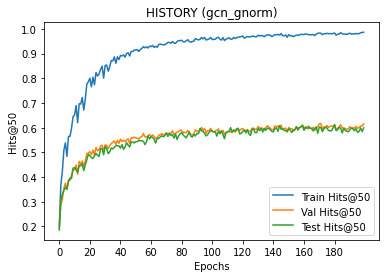

In [ ]:
plot_history(history, train_hits, val_hits, test_hits, N_EPOCHS, model_type)

In [ ]:
print(f'Val: {val_hit}, Test:  {test_hit}')

Val: 0.6157712535783236, Test:  0.5990848064926936
